In [23]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Import estimators and transformers
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from src.features import CustomEncoder

# Import predictors
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext autoreload
%autoreload 2

path_processed = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/processed/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
df = pd.read_csv(path_processed+'data_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8714 entries, 0 to 8713
Data columns (total 57 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Tipologia                                  8714 non-null   object 
 1   Tipo_proprietà                             8277 non-null   object 
 2   Zona                                       8714 non-null   object 
 3   Anno_costruzione                           6334 non-null   float64
 4   Stato                                      8483 non-null   object 
 5   Prezzo_EUR                                 8714 non-null   float64
 6   Superficie_m2                              8714 non-null   float64
 7   Prezzo_per_m2                              8714 non-null   float64
 8   Riscaldamento_A_C                          8714 non-null   object 
 9   Tipo_riscaldamento                         6760 non-null   object 
 10  Alimentazione_riscaldame

In [13]:
df['Prezzo_EUR'].describe()

count       8714.000
mean      481863.318
std       659474.582
min          700.000
25%       248000.000
50%       339000.000
75%       501000.000
max     28000000.000
Name: Prezzo_EUR, dtype: float64

It is clear that our target variable Price has a large number of outliers and these lead to a large standard deviation (larger than the mean). Let's see how this influences our predictions.

<AxesSubplot:>

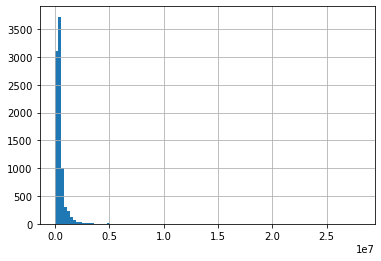

In [16]:
df['Prezzo_EUR'].hist(bins=100)

## Issues and next steps
- One-hot encode the categorial variables after imputation? - Cannot do that because imputes with continuous values
- Change imputation method - Used most frequent and mean, results are slightly better.
- PCA? - Used PCA after OH encoding, tuning it made barely any difference
- Drop entries instead of imputing? - Slight improvement
- Remove/winsorize outliers? Our std is larger than our mean. Where are these outliers coming from? - Dropping outliers completely drastically improves predictions.
- Feature selection?
- Understand what a good value for the metric is! - Our baseline model establishes a benchmark
- Ensemble models?

### 1. Feature selection and splitting data

In [25]:
target = 'Prezzo_EUR'

X = df.drop(columns=['Prezzo_per_m2']+[target])
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 2. Pre-processing pipeline

In [26]:
cat_features = ['Tipologia', 'Zona', 'Stato', 'Tipo_proprietà', 'Riscaldamento_A_C', 'Tipo_riscaldamento',
                'Alimentazione_riscaldamento', 'Classe_energetica', 'Piano']
num_features = ['Superficie_m2', 'Num_bagni', 'Num_tot_locali', 'Anno_costruzione']

# cat_features = ['Tipologia', 'Zona', 'Tipo_proprietà', 'Tipo_riscaldamento', 'Classe_energetica']
# num_features = ['Superficie_m2', 'Num_tot_locali']

cat_transformer = Pipeline([
    ('label_encoding', CustomEncoder()),
    ('imputing', IterativeImputer(initial_strategy='most_frequent', max_iter=10, random_state=0)),
#    ('oh_encoding', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline([
    ('scaling', StandardScaler()),
    ('imputing', IterativeImputer(initial_strategy='mean', max_iter=10, random_state=0))
])

preprocessing_pipeline = ColumnTransformer([
    ('categoricals', cat_transformer, cat_features),
    ('numericals', num_transformer, num_features)
],
    remainder='passthrough'
)

### 2. Modeling

#### 2.1 First model (benchmarking)

In [27]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', LinearRegression())
])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 142758.57216963812
Mean cross validation score: 148856.3810340354


Considering a mean of our target variable Price of **481'863** EUR and a std of **659'475** EUR, an MAE of **142'759** EUR on the training set is not great.

There isn't a huge difference in scores between the training and test sets so this model is most probably suffering from high bias. It lacks in complexity despite the number of features in our dataset (roughly 60) and is therefore not powerful enough to fit our training set well.

We will keep these results as a baseline to benchmark from.

#### 2.2 Other models

In [14]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', Ridge())
])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 142702.85749248794
Mean cross validation score: 148751.77269511853


Marginally better than the simple linear regression. As expected, this model also suffers from high bias.

In [ ]:
# Regularization parameter
alphas = []
train_scores = []
test_scores = []
for i in range(100):
    alpha = i
    alphas.append(alpha)
    
    rr = Ridge(alpha=alpha)
    pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', rr)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
    train_scores.append(mean_absolute_error(y_train, y_pred))
    scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    test_scores.append(np.mean(-scores))

In [ ]:
plt.plot(alphas, train_scores)
plt.plot(alphas, test_scores)
plt.show()

In [15]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', RandomForestRegressor(random_state=0))
])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 38032.5498374217
Mean cross validation score: 101494.51376120746


The results here are quite different compared to our previous linear models. The MAE on the training set is now at **38'033** EUR which is much better. The MAE on the test set however is much larger, at **101'495** EUR, meaning that this model most probably suffers from high variance.

We will surely need to regularize the model to prevent it from overfitting the training set and allow it to generalize well to data it hasn't yet seen (test set). We will do this via hyperparameter tuning.

In [21]:
from sklearn.svm import SVR

pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', SVR())
])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 242063.91309916164
Mean cross validation score: 242121.6146724021


The SVC is the worst model yet, dramatically underfitting the training set with an MAE at **242'063** EUR. We will not consider this model from here on out.

### 3. Hyperparameter tuning

In [19]:
rf = RandomForestRegressor(random_state=0)

pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', rf)
])

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 4)]
# Number of features to consider at every split
max_features = [2, 3, 4]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Split criterion
criterion = ['mse', 'mae']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
#param_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'criterion': criterion,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

param_grid = [
{'model__n_estimators': [20, 30, 40], 'model__max_features': [6, 8, 10], 'model__min_samples_split': [2, 5, 10],
 'model__min_samples_leaf': [1, 2, 4]},
#{'model__bootstrap': [False], 'model__n_estimators': [3, 10], 'model__max_features': [2, 3, 4]},
]

grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=0, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

113754.411049257 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 20}
111608.07312144418 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 30}
111437.03706403139 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 40}
115539.04081124754 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 20}
112641.48061626844 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 30}
111547.63596452307 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 40}
116508.62916741215 {'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 20}
114642.36728287167 {'model__max_features': 6, 'model__min_sampl

In [20]:
pipe = grid_search.best_estimator_

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))

Training set score: 41927.12008957745
Mean cross validation score: 105196.66061831175


Tuning the random forest model hasn't helped a great deal. The training set MAE has increased which confirms that we've regularized the model but the test set MAE is still very high.

We will not spend too much time tuning our models, rather we will look into the data more.